In [9]:
import numpy as np
import sympy as sp
from scipy.integrate import quad
from tqdm import tqdm

In [10]:
def construct_A(n):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = double_taylor_series(matrix_A,item)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n+1)))
    return Lambda_diag - matrix_A

In [11]:
def double_taylor_series(matrix_A,pos):
    global basis_point
    global basis_list    
    global K
    t = basis_point[pos[0]]
    fi = basis_list[pos[1]]
    n_y = K.subs(x,t)*fi.subs(x,y)
    n_y_numpy = sp.lambdify(y,n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    n_result,_ = quad(n_y_numpy,begin,end)
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [12]:
def generate_basis(method,begin,end,n):
    feature = 2*sp.pi/(end-begin)
    x = sp.Symbol('x')
    basis_list = []
    basis_point = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
            basis_point.append(begin+i*skip)  
    if method == 'trigo':
        skip = (end-begin)*2*sp.pi/(2*n+1)/feature
        for i in tqdm(range(2*n+1)):
            temp_begin = begin+i*skip
            basis_list.append(1/(2*n+1)*sp.sin(feature*(n+1/2)*(x-temp_begin))/sp.sin((x-temp_begin)/2*feature))
            basis_point.append(temp_begin)
    return basis_list,basis_point

In [13]:
tolerance = 10**(-8)
x = sp.Symbol('x')
y = sp.Symbol('y')
Lambda = 1
K = sp.exp(x*y**2) 
g = x+(1-sp.exp(x))/(2*x)
f_origin = x
begin = 0
end = 1
n = 20
method = 'trigo'

In [14]:
basis_list,basis_point = generate_basis(method,begin,end,n)

100%|██████████| 41/41 [00:00<00:00, 160.08it/s]


In [15]:
if method == 'linear':
    m = n
elif method == 'trigo':
    m = 2*n

In [16]:
A_n = construct_A(m)

100%|██████████| 1681/1681 [00:03<00:00, 528.27it/s]


In [17]:
# 计算得到 c
y_ = sp.zeros(m+1,1)
for i in tqdm(range(m+1)):
    try:
        y_[i, 0] = g.evalf(subs={x:basis_point[i]})
    except Exception:
        y_[i, 0] = g.evalf(subs = {x:basis_point[i]+tolerance})
A_n_acce = np.matrix(A_n).astype(np.float64)
A_n_acce_inv = A_n_acce**(-1)
A_n_inv = sp.Matrix(A_n_acce_inv)
c = A_n_inv*y_

100%|██████████| 41/41 [00:00<00:00, 5242.88it/s]


In [18]:
result = 0
for i in range(m+1):
    result = result + basis_list[i]*c[i,0]

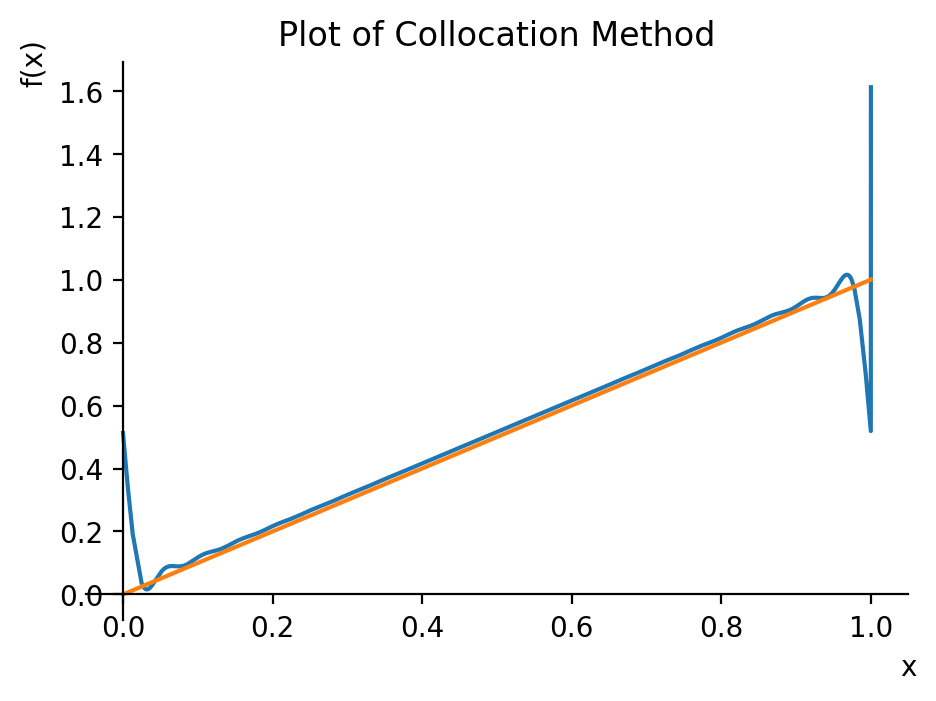

In [19]:
p = sp.plotting.plot(result,(x,begin,end),show=False)
p_origin = sp.plotting.plot(f_origin,(x,begin,end),show=False)
p.append(p_origin[0])
p.title = 'Plot of Collocation Method'
p.show()

In [20]:
err_func = sp.lambdify(x,(result-f_origin)**2,'numpy')

In [21]:
err = quad(err_func,begin,end,limit=n)
print(err[0])

0.0034259189954700783
